Name!

## 1. Import and display audio files

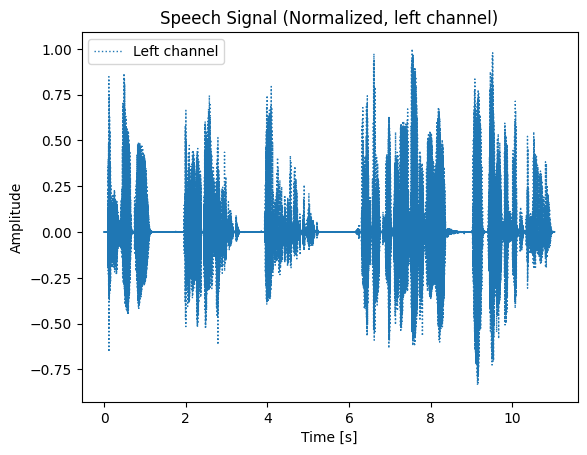

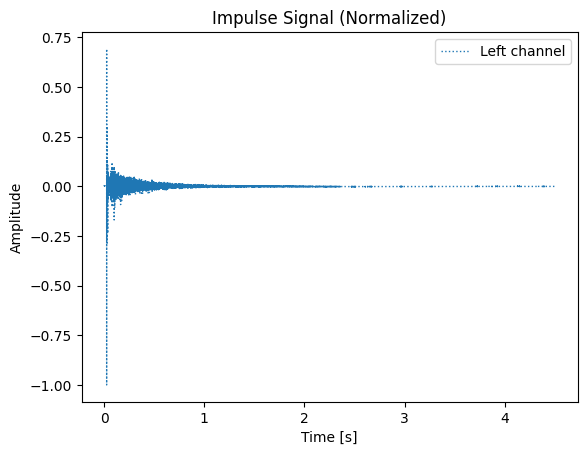

In [37]:
import os
from pathlib import Path
import scipy as sp
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt

path_folder = Path.cwd()
path_speech = path_folder / 'speech.wav' 
path_impuls = path_folder / 'impulse_response.wav'
x = sp.io.wavfile.read(path_speech)
h = sp.io.wavfile.read(path_impuls)
sr_x, data_x = sp.io.wavfile.read(path_speech)
sr_h, data_h = sp.io.wavfile.read(path_impuls)

length_x = data_x.shape[0] / sr_x
length_h = data_h.shape[0] / sr_h


time_x = np.linspace(0., length_x, data_x.shape[0])
max_amp_x = np.max(np.abs(data_x[:, 0])) # Normalize based on left channel
plt.plot(time_x, data_x[:, 0] / max_amp_x, label="Left channel",linestyle=':', linewidth=1)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Speech Signal (Normalized, left channel)")
plt.show()


time_h = np.linspace(0., length_h, data_h.shape[0])
max_amp_h = np.max(np.abs(data_h)) # Normalize based on left channel
plt.plot(time_h, data_h / max_amp_h, label="Left channel",linestyle=':', linewidth=1)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Impulse Signal (Normalized)")
plt.show()

## 2. System properties

## 3. Convlution

### a)

### b) 